In [1]:
#imports
%matplotlib notebook
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam

#generating approximately linear data from python func
from lin_reg_data import getLinRegDatasets

In [2]:
# training parameters
num_epochs = 30
batch_size = 32

lr = 0.01
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Mon Sep 13 19:29:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   33C    P8    23W / 250W |    407MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:0'

In [5]:
#init datasets and dataloaders

#setting data parameters
num_train = 5000
num_test = 100
y_dim = 20
x_dim = 20
m_var = 0.25
b_var = 0.25

#setting random number seed for data generation
np.random.seed(seed=0)

train_set, test_set, m, b = getLinRegDatasets(num_train, num_test,
                                            x_dim=x_dim, y_dim=y_dim,
                                            m_var=m_var, b_var=b_var)

train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_set, batch_size=batch_size, shuffle=True)


In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin = nn.Linear(x_dim, y_dim)
        self.param_updates = 0

    def forward(self, x):
        return self.lin(x)
    
loss_fn = nn.MSELoss()
model = Model()
model.to(device)

Model(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)

In [7]:
#getting number of parameters in model
num_params = n_params(model, verbose=True)

#defing arrays to store model paramter states as it trains
num_param_states = num_epochs*len([0 for val in train_data])+1
# +1 so that I can include initial parameter state
param_states = np.zeros((num_param_states, num_params))
print('param states shape:', param_states.shape)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=num_param_states)

#the step corresponding to the end of an epoch
epoch_indices = np.zeros((num_epochs+1))

train_loss = np.zeros((num_param_states))
ep_train_loss = np.zeros((num_epochs+1))
test_loss = np.zeros((num_epochs+1))

#storing adam inst. stuff
grads = np.zeros_like(param_states)
m1s = np.zeros_like(param_states)
m2s = np.zeros_like(param_states)

lin.weight size: 10000
lin.bias size: 100
Total num. parameters: 10100
param states shape: (15701, 10100)


In [8]:
def train(dataloader, model, loss_fn, optimizer, param_states,
          train_loss=train_loss, grads=grads, m1s=m1s, m2s=m2s):
    size = len(dataloader)
    
    total_loss = 0.0

    if model.param_updates == 0:
        param_states[model.param_updates] = get_param_state(model)
        model.param_updates += 1

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        #CostLrUpdate(loss.item(), lr, optimizer)

        optimizer.zero_grad()
        loss.backward()
        grad, m1, m2, _ = optimizer.step()

        grads[model.param_updates-1] = np.concatenate([g.flatten() for g in grad])
        m1s[model.param_updates-1] = np.concatenate([m.flatten() for m in m1])
        m2s[model.param_updates-1] = np.concatenate([m.flatten() for m in m2])
        
        param_states[model.param_updates] = get_param_state(model)

        train_loss[model.param_updates] = loss.item()
        total_loss += loss.item()

        model.param_updates += 1

    return total_loss/size

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_minibatches
    return test_loss

In [9]:
model.param_updates=0

# Choose optimizer

#optimizer = GDMethod(model.parameters(), lr=lr)
#optimizer = MomentumMethod(model.parameters(), lr=lr)
#optimizer = Adagrad(model.parameters(), lr=lr)
#optimizer = RMSProp(model.parameters(), lr=lr, ema_coeff=0.9)
optimizer = Adam(model.parameters(), lr=lr, betas=betas)

#Getting initial train and test loss
train_loss[0] = test(train_data, model, loss_fn)
ep_train_loss[0] = test(train_data, model, loss_fn)
test_loss[0] = test(test_data, model, loss_fn)

for j in range(num_epochs):
    print(' - Epoch: %i'%(j+1))

    # Choose lr scheduler
    
    #this_lr = LinearLrUpdate(j, lr, optimizer, decay_rate=2)
    #this_lr = StepLrUpdate(j, lr, optimizer, decay_rate=0.5, drop_rate=10)
    #this_lr = ExpLrUpdate(j, lr, optimizer, decay_rate=0.1)

    ep_train_loss[j+1] = train(train_data, model, loss_fn, optimizer, param_states, train_loss)
    test_loss[j+1] = test(test_data, model, loss_fn)
    epoch_indices[j+1] = model.param_updates-1

steps = param_states[1:] - param_states[:-1]

 - Epoch: 1
 - Epoch: 2
 - Epoch: 3
 - Epoch: 4
 - Epoch: 5
 - Epoch: 6
 - Epoch: 7
 - Epoch: 8
 - Epoch: 9
 - Epoch: 10
 - Epoch: 11
 - Epoch: 12
 - Epoch: 13
 - Epoch: 14
 - Epoch: 15
 - Epoch: 16
 - Epoch: 17
 - Epoch: 18
 - Epoch: 19
 - Epoch: 20
 - Epoch: 21
 - Epoch: 22
 - Epoch: 23
 - Epoch: 24
 - Epoch: 25
 - Epoch: 26
 - Epoch: 27
 - Epoch: 28
 - Epoch: 29
 - Epoch: 30
 - Epoch: 31
 - Epoch: 32
 - Epoch: 33
 - Epoch: 34
 - Epoch: 35
 - Epoch: 36
 - Epoch: 37
 - Epoch: 38
 - Epoch: 39
 - Epoch: 40
 - Epoch: 41
 - Epoch: 42
 - Epoch: 43
 - Epoch: 44
 - Epoch: 45
 - Epoch: 46
 - Epoch: 47
 - Epoch: 48
 - Epoch: 49
 - Epoch: 50
 - Epoch: 51
 - Epoch: 52
 - Epoch: 53
 - Epoch: 54
 - Epoch: 55
 - Epoch: 56
 - Epoch: 57
 - Epoch: 58
 - Epoch: 59
 - Epoch: 60
 - Epoch: 61
 - Epoch: 62
 - Epoch: 63
 - Epoch: 64
 - Epoch: 65
 - Epoch: 66
 - Epoch: 67
 - Epoch: 68
 - Epoch: 69
 - Epoch: 70
 - Epoch: 71
 - Epoch: 72
 - Epoch: 73
 - Epoch: 74
 - Epoch: 75
 - Epoch: 76
 - Epoch: 77
 - Epoch

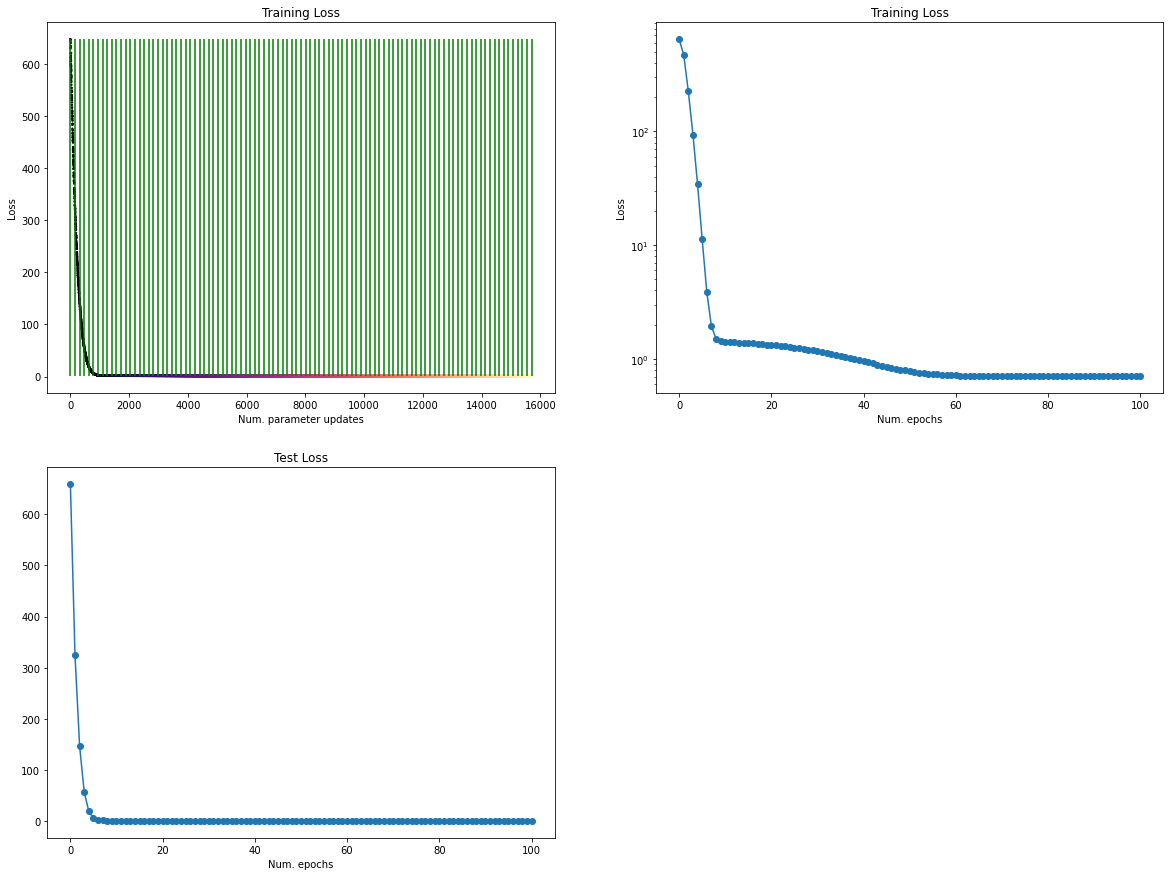

In [10]:
time = np.array([i for i in range(num_param_states)])

#plotting loss over training
plt.figure()
plt.subplot(2, 2, 1)
plt.title('Training Loss')
plt.xlabel('Num. parameter updates')
plt.ylabel('Loss')
plt.scatter(time, train_loss, c=cm.magma(time/(num_param_states-1)), s=2)
plt.vlines(epoch_indices, min(train_loss), max(train_loss), linestyle='solid', colors='g')

plt.subplot(2, 2, 2)
plt.title('Training Loss')
plt.xlabel('Num. epochs')
plt.ylabel('Loss')
plt.yscale('log')
#plt.plot(train_loss[[int(_) for _ in epoch_indices]], 'o-')
plt.plot(ep_train_loss, 'o-')

#plotting loss over testing
plt.subplot(2, 2, 3)
plt.title('Test Loss')
plt.xlabel('Num. epochs')
plt.plot(test_loss, 'o-')

# plt.subplot(2, 2, 4)
# plt.title('Test Acc.')
# plt.xlabel('Num. epochs')
# plt.plot(test_acc, 'o-')

In [11]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [12]:
from sklearn.decomposition import PCA
print('PCA fitting:')

pca = PCA(n_components=2)
pca.fit(param_states)
pca_embed = pca.transform(param_states)
print('components_ shape:', pca.components_.shape, '\nsamples shape:', param_states.shape, '\ntransformed shape:', pca_embed.shape)

print("PCA explains", pca.explained_variance_ratio_, '->', sum(pca.explained_variance_ratio_)*100, '% of variance')

PCA fitting:
components_ shape: (2, 10100) 
samples shape: (15701, 10100) 
transformed shape: (15701, 2)
PCA explains [0.83606751 0.16148716] -> 99.75546769419785 % of variance


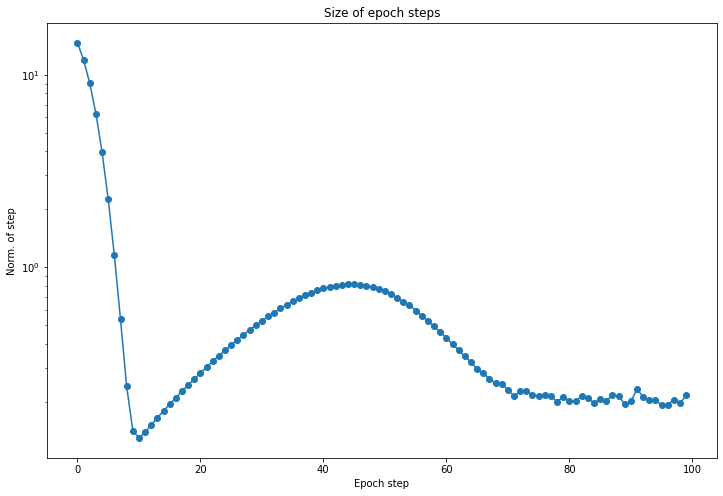

In [24]:
#plotting size of epoch step
plt.figure()
plt.title("Size of epoch steps")
plt.xlabel("Epoch step")
plt.ylabel("Norm. of step")
plt.yscale('log')
plt.plot([np.linalg.norm(param_states[int(epoch_indices[i+1])]-param_states[int(epoch_indices[i])]) for i in range(len(epoch_indices)-1)], 'o-')

In [14]:
epoch_states = np.array([param_states[int(epoch_indices[i])] for i in range(num_epochs+1)])

epoch_steps = np.array([epoch_states[i+1]-epoch_states[i] for i in range(num_epochs)])

epoch_states_embed = pca.transform(epoch_states)
epoch_steps_embed = np.array([epoch_states_embed[i+1]-epoch_states_embed[i] for i in range(num_epochs)])

(101, 10100)
(100, 10100)
[[25.15345315 45.23076368]
 [22.68028856 30.82412754]]
[ -2.47316459 -14.40663613]


-12.602751883039353 1.0392184719339386


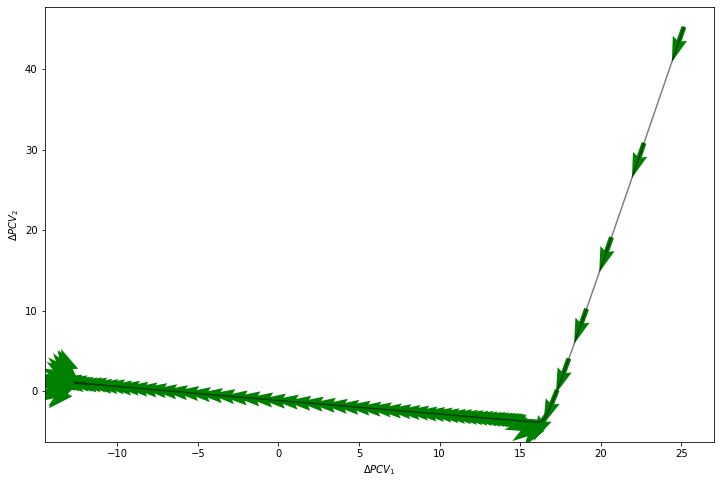

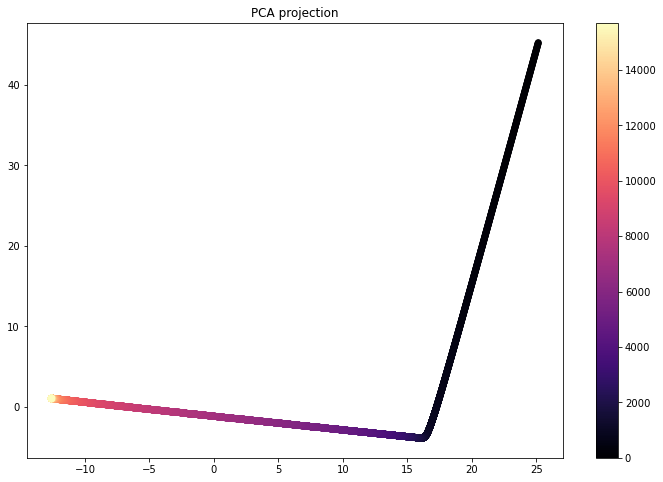

In [15]:
fig, ax = plt.subplots()
ax.plot(pca_embed[:,0], pca_embed[:,1], c='k', alpha=0.5)
#ax.scatter(epoch_states_embed[:,0], epoch_states_embed[:,1], c='g')
for i in range(num_epochs):
    ax.quiver(epoch_states_embed[i,0], epoch_states_embed[i,1], epoch_steps_embed[i,0], epoch_steps_embed[i,1], angles='xy', color='g')
    #print(epoch_states_embed[i,0], epoch_states_embed[i,1], epoch_steps_embed[i,0], epoch_steps_embed[i,1])
    #ax.arrow(epoch_states_embed[i,0], epoch_states_embed[i,1], epoch_steps_embed[i,0], epoch_steps_embed[i,1],
    #         color='g', width=0.5, head_width=1, length_includes_head=True)
ax.set_xlabel('$\Delta PCV_{1}$')
ax.set_ylabel('$\Delta PCV_{2}$')
print(*[epoch_states_embed[i,0], epoch_states_embed[i,1]])

plt.figure(figsize=(12, 8))
plt.title('PCA projection')
plt.scatter(pca_embed[:, 0], pca_embed[:,1], c=[val for val in cmap(time/(num_param_states-1))])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))

Text(0, 0.5, 'Change in train loss / size epoch step')

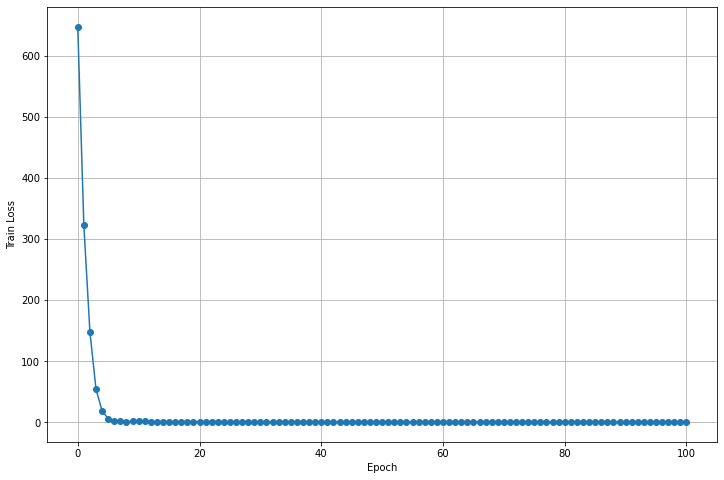

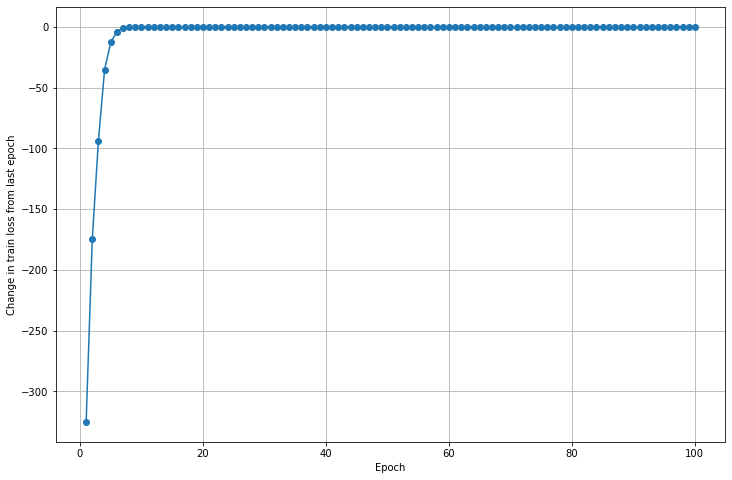

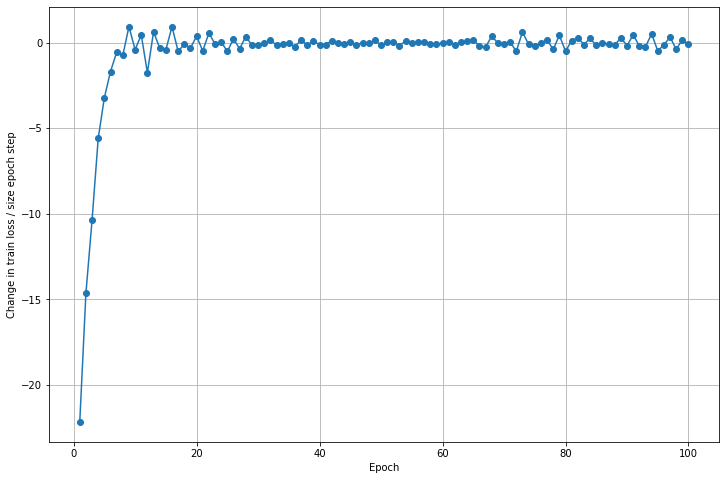

In [16]:
epoch_train_loss = np.asarray(train_loss[[int(v) for v in epoch_indices]])

# looking at the change in loss between epochs

plt.figure()
plt.plot(np.arange(0, num_epochs+1), epoch_train_loss, 'o-')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Train Loss")

change_epoch_train_loss = epoch_train_loss[1:] - epoch_train_loss[:-1]

plt.figure()
plt.plot(np.arange(1, num_epochs+1), change_epoch_train_loss, 'o-')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Change in train loss from last epoch")

plt.figure()
plt.plot(np.arange(1, num_epochs+1), change_epoch_train_loss / np.linalg.norm(epoch_steps, axis=-1), 'o-')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Change in train loss / size epoch step")

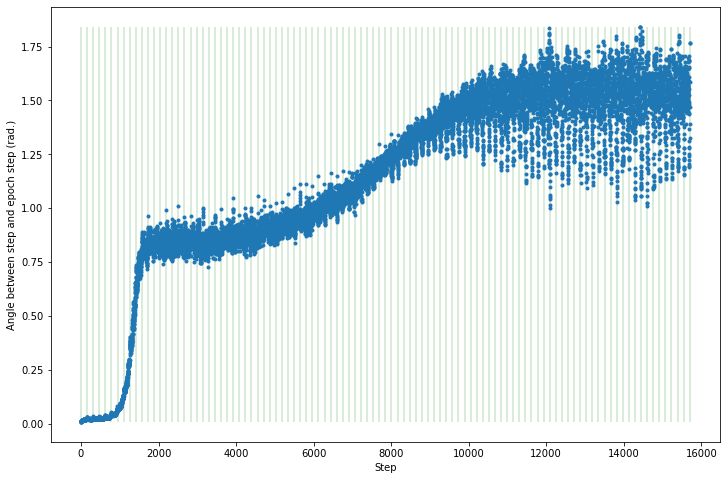

In [17]:
step_dot_prod = np.zeros((num_param_states-1))
for i in range(len(epoch_steps)):
    this_epoch_grad = epoch_steps[i]
    #print("step:", i, 'to', i+1)
    #print('states:', epoch_indices[i+1], 'to', epoch_indices[i+2])
    #for j in range(int(epoch_indices[i+1]), int(epoch_indices[i+2])):
    for j in range(int(epoch_indices[i]), int(epoch_indices[i+1])):
        #print(j, np.dot(steps[j], this_epoch_grad))
        step_dot_prod[j] = np.arccos(np.dot(steps[j], this_epoch_grad)/(np.linalg.norm(steps[j])*np.linalg.norm(this_epoch_grad)))
        #step_dot_prod[j] = np.dot(steps[j], this_epoch_grad)/(np.linalg.norm(steps[j])*np.linalg.norm(this_epoch_grad))

plt.figure(figsize=(12,8))
plt.vlines(epoch_indices, ymin=min(step_dot_prod), ymax=max(step_dot_prod), color='g', alpha=0.2)
#plt.hlines([np.pi/2], xmin=0, xmax=epoch_indices[-1], linestyle='dashed')
plt.xlabel("Step")
plt.ylabel("Angle between step and epoch step (rad.)")
plt.plot(step_dot_prod, '.')
#plt.xlim((0, 50))
        

Text(0, 0.5, 'Angle between grad and epoch step (rad.)')

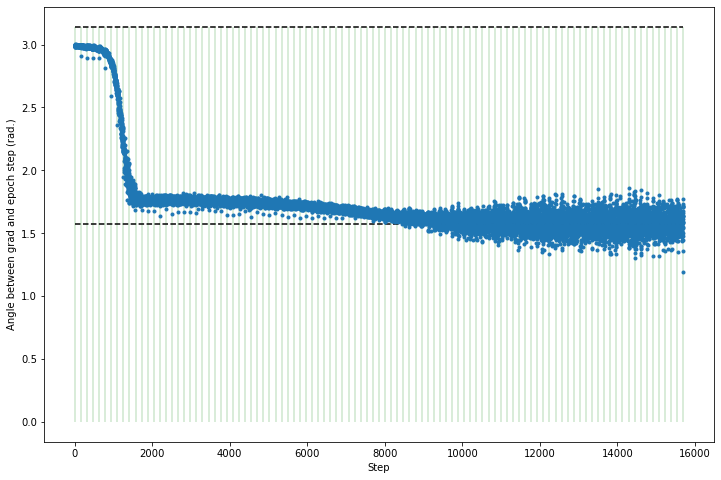

In [18]:
grad_dot_prod = np.zeros((num_param_states-1))
for i in range(len(epoch_steps)):
    this_epoch_grad = epoch_steps[i]
    #print("step:", i, 'to', i+1)
    #print('states:', epoch_indices[i+1], 'to', epoch_indices[i+2])
    for j in range(int(epoch_indices[i]), int(epoch_indices[i+1])):
    #for j in range(int(epoch_indices[i+1]), int(epoch_indices[i+2])):
        #print(j, np.dot(steps[j], this_epoch_grad))
        grad_dot_prod[j] = np.arccos(np.dot(grads[j], this_epoch_grad)/(np.linalg.norm(grads[j])*np.linalg.norm(this_epoch_grad)))      
        
plt.figure()
plt.vlines(epoch_indices, ymin=0, ymax=np.pi, color='g', alpha=0.2)
plt.hlines([np.pi/2, np.pi], xmin=0, xmax=epoch_indices[-1], linestyle='dashed')
plt.plot(grad_dot_prod, '.')
plt.xlabel("Step")
plt.ylabel("Angle between grad and epoch step (rad.)")
#plt.xlim((0, 50))

Text(0, 0.5, 'Angle between grad and ave. grad over epoch (rad.)')

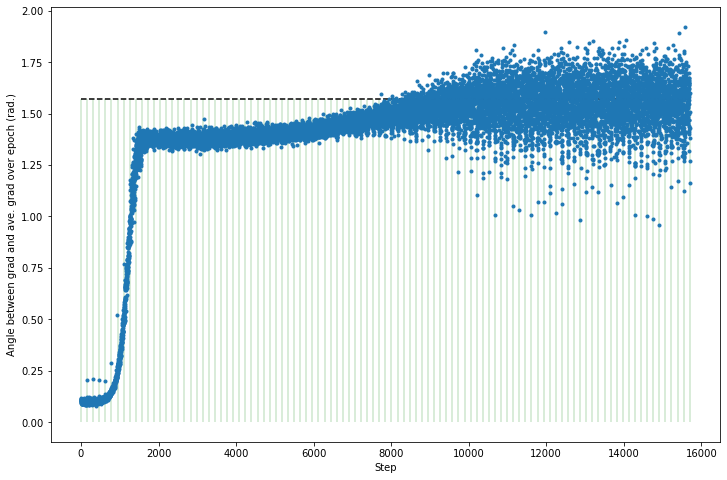

In [19]:
grad_dot_prod_withave = np.zeros((num_param_states))
for i in range(len(epoch_steps)):
    this_ave_grad = np.mean(grads[int(epoch_indices[i]):int(epoch_indices[i+1])], axis=0)
    for j in range(int(epoch_indices[i]), int(epoch_indices[i+1])):
        grad_dot_prod[j] = np.arccos(np.dot(grads[j], this_ave_grad)/(np.linalg.norm(grads[j])*np.linalg.norm(this_ave_grad)))
       
plt.figure()
plt.vlines(epoch_indices, ymin=0, ymax=np.pi/2, color='g', alpha=0.2)
plt.hlines([np.pi/2], xmin=0, xmax=epoch_indices[-1], linestyle='dashed')
plt.plot(grad_dot_prod, '.')
plt.xlabel("Step")
plt.ylabel("Angle between grad and ave. grad over epoch (rad.)")

sum of pred loss change: -692.2900783931714
sum of actual loss change: -646.991260295461
Mean diff. 0.0028852750380710264


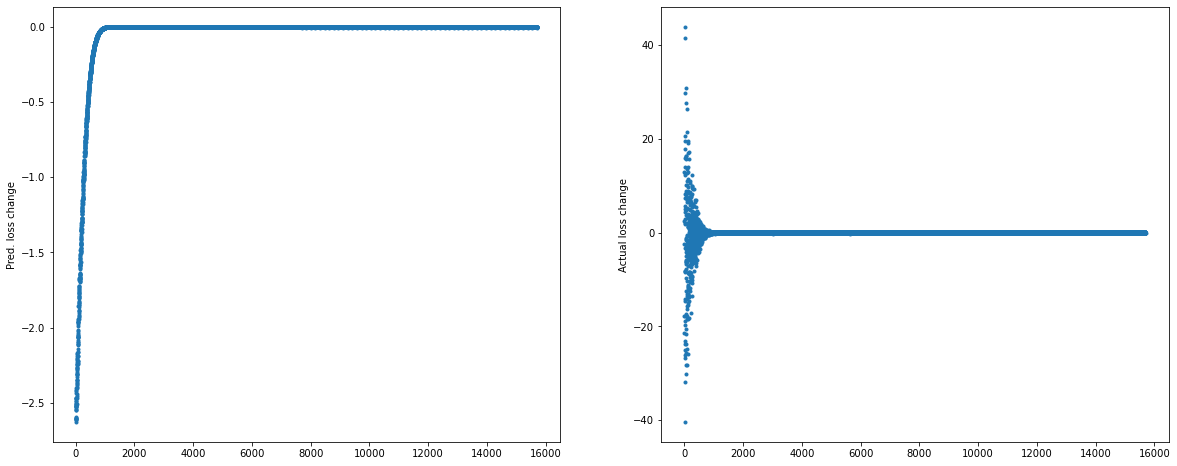

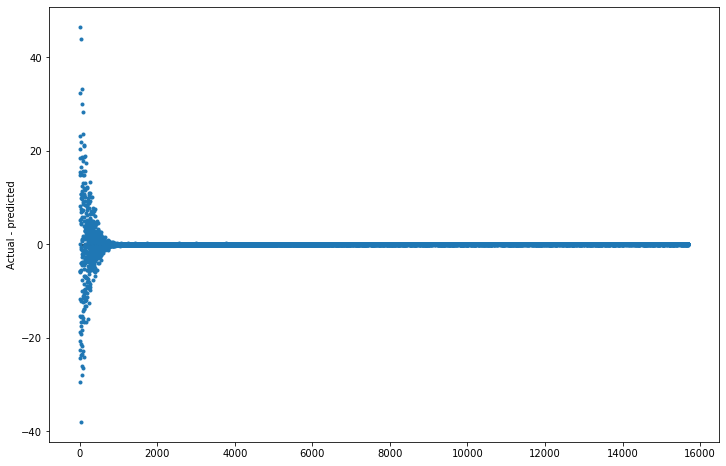

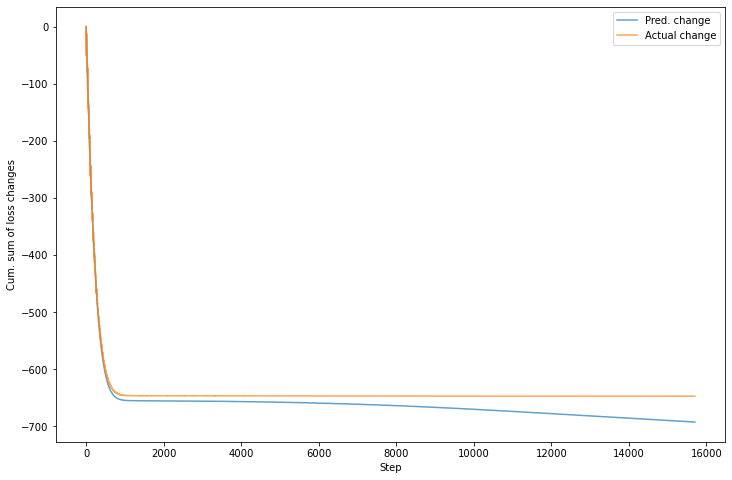

In [20]:
pred_loss_change = -1*np.multiply(np.linalg.norm(steps, axis=-1), np.linalg.norm(grads[:-1], axis=-1)) #size of step times size of grad
actual_loss_change = train_loss[1:] - train_loss[:-1]

# comparing the loss change for each step predicted b ythe gradient with the actual change

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(pred_loss_change, '.')
plt.ylabel("Pred. loss change")

print("sum of pred loss change:",  sum(pred_loss_change))

plt.subplot(1, 2, 2)
plt.plot(actual_loss_change, '.')
plt.ylabel("Actual loss change")

print("sum of actual loss change:", sum(actual_loss_change))

plt.figure()
plt.plot(actual_loss_change - pred_loss_change, '.')
plt.hlines([np.mean(actual_loss_change - -1*pred_loss_change)], xmin=0, xmax=num_param_states-1)
plt.ylabel("Actual - predicted")
print("Mean diff.", np.mean(actual_loss_change - pred_loss_change))

plt.figure()
plt.plot([sum(pred_loss_change[0:i]) for i in range(num_param_states)], label='Pred. change', alpha=0.7)
plt.plot([sum(actual_loss_change[0:i]) for i in range(num_param_states)], label="Actual change", alpha=0.7)
plt.ylabel("Cumulative sum of loss changes")
plt.xlabel("Step")
plt.legend()


Text(0.5, 0, 'Epoch step')

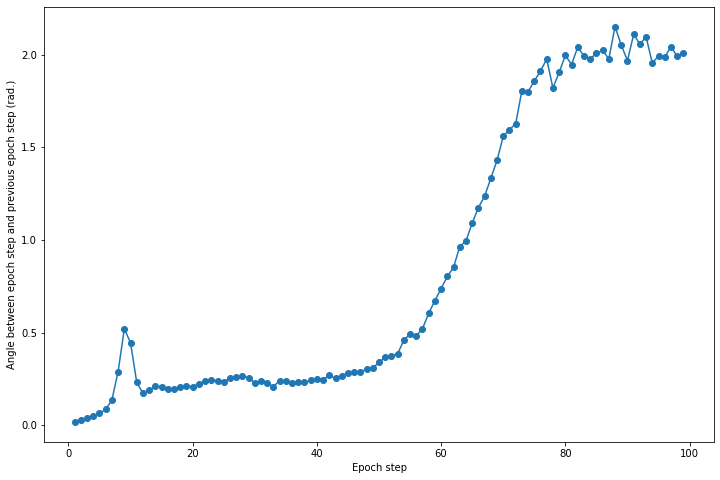

In [21]:
plt.figure()
plt.plot([i+1 for i in range(len(epoch_steps)-1)], [np.arccos(np.dot(epoch_steps[i+1], epoch_steps[i])/(np.linalg.norm(epoch_steps[i+1])*np.linalg.norm(epoch_steps[i]))) for i in range(len(epoch_steps)-1)], 'o-')
plt.ylabel("Angle between epoch step and previous epoch step (rad.)")
plt.xlabel("Epoch step")

0.0 2.1503229504016166


Text(0, 0.5, 'Step j')

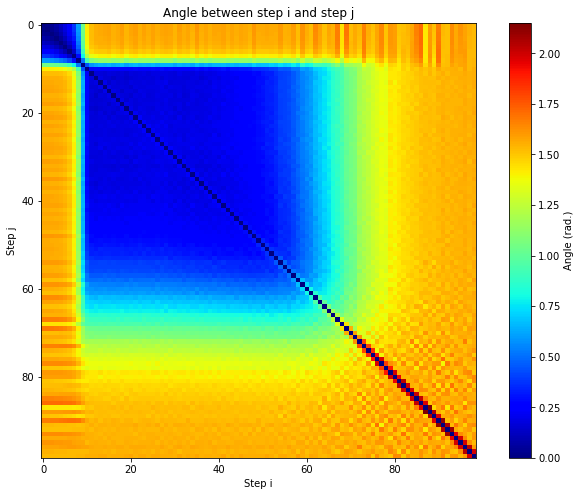

In [22]:
def angle_between(i, j, epoch_steps=epoch_steps):
    if i == j:
        return 0
    else:
        #print(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))
        return np.arccos(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))

def normed_dot(i, j, epoch_steps=epoch_steps):
    if i == j:
        return 0
    else:
        #print(np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j])))
        return np.dot(epoch_steps[i], epoch_steps[j])/(np.linalg.norm(epoch_steps[i])*np.linalg.norm(epoch_steps[j]))
    
    
angle_grid = np.zeros((num_epochs-1, num_epochs-1))

for i in range(num_epochs-1):
    for j in range(num_epochs-1):
        angle_grid[i, j] = angle_between(i, j)
        #angle_grid[i, j] = normed_dot(i, j)
        
import matplotlib.colors as colors
norm1 = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))        

print(np.amin(angle_grid), np.amax(angle_grid))

plt.figure()
plt.imshow(angle_grid, cmap=cm.jet)
plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cm.jet), label='Angle (rad.)')
plt.title('Angle between step i and step j')
plt.xlabel('Step i')
plt.ylabel('Step j')

time: 0.6928894519805908
time: 0.6296803951263428
time: 0.7673354148864746
time: 0.6984233856201172
time: 0.5521841049194336
time: 0.5667614936828613
time: 0.5801742076873779
time: 0.5695571899414062
time: 0.5650253295898438
time: 0.5626537799835205
time: 0.5719311237335205
time: 0.5710694789886475
time: 0.5657675266265869
time: 0.563370943069458
time: 0.5767567157745361
time: 0.5607709884643555
time: 0.5706884860992432
time: 0.5753364562988281
time: 0.5727424621582031
time: 0.5651869773864746
time: 0.5600388050079346
time: 0.5670216083526611
time: 0.5684943199157715
time: 0.5617833137512207
time: 0.5629973411560059
time: 0.5662410259246826
time: 0.6093380451202393
time: 0.5845932960510254
time: 0.6027243137359619
time: 0.6046380996704102
time: 0.5958831310272217
time: 0.583733081817627
time: 0.588369607925415
time: 0.5663728713989258
time: 0.5484511852264404
time: 0.5561361312866211
time: 0.5481040477752686
time: 0.5577478408813477
time: 0.5531854629516602
time: 0.5525352954864502
tim

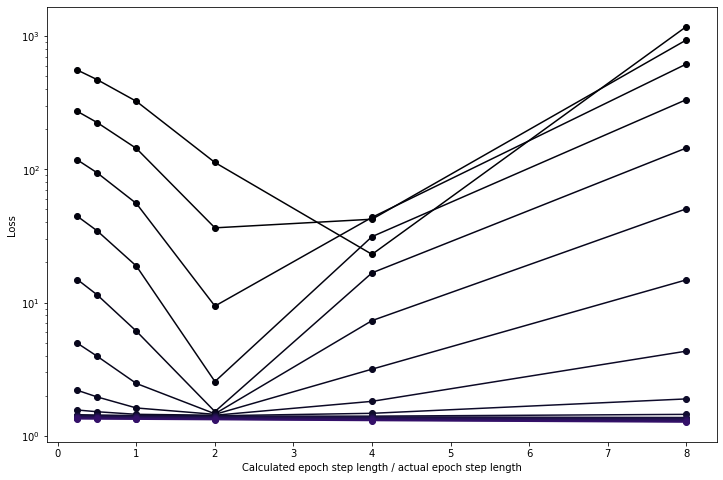

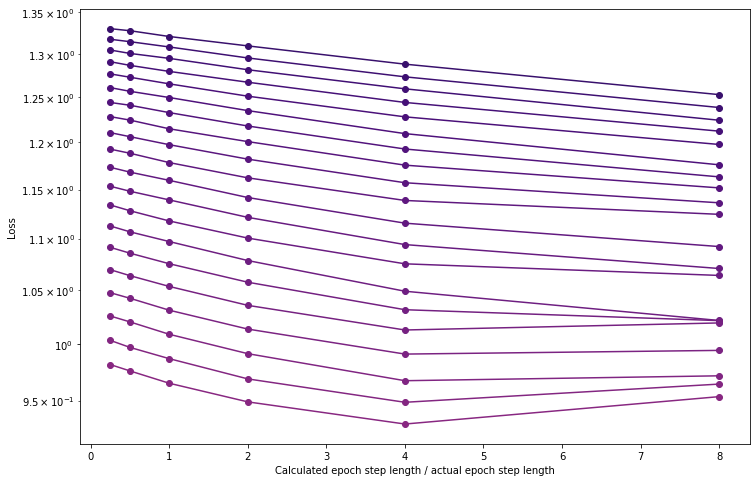

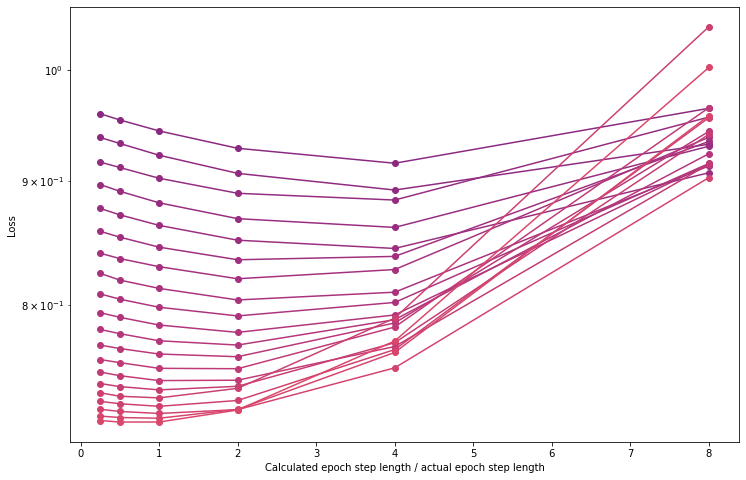

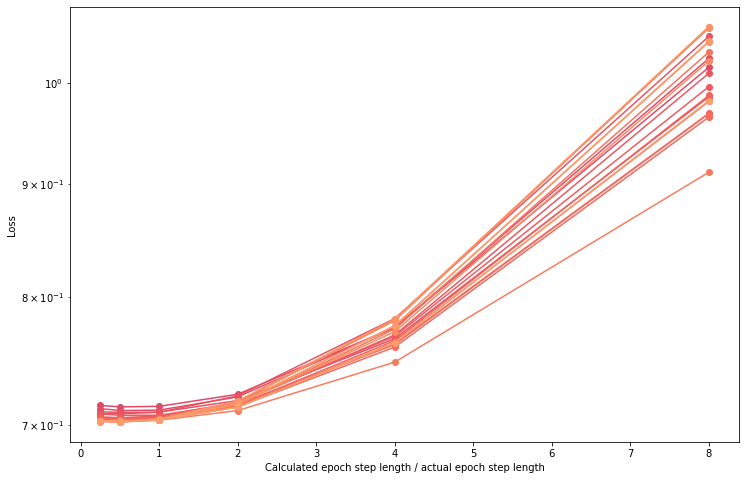

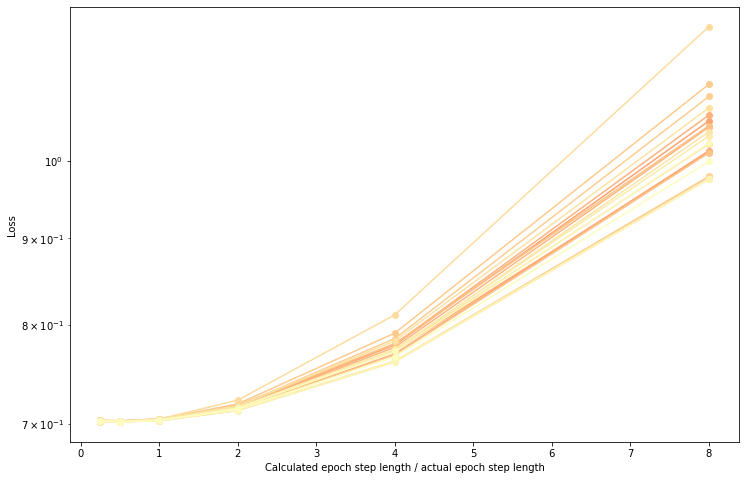

In [23]:
import time 
def scan_ahead(state_idx, num_steps=1, steps=[2**i for i in range(-2, 4)], epoch_states=epoch_states):
    losses = []
    for step in steps:
        #print(epoch_states[state_idx].shape, (epoch_states[state_idx+num_steps]-epoch_states[state_idx]).shape)
        param_state = epoch_states[state_idx] + step*(epoch_states[state_idx+num_steps]-epoch_states[state_idx])
        model.load_state_dict(vector_to_state_dict(param_state, model))
        this_loss = test(train_data, model, loss_fn)
        losses.append(this_loss)
    return steps, losses

colors = cm.magma(np.linspace(0, 1, num_epochs-1))

plt.figure()
plt.xlabel('Calculated epoch step length / actual epoch step length')
plt.ylabel('Loss')
plt.yscale('log')

for i in range(num_epochs-1):
    
    if (i+1) % 20 == 0:
        plt.figure(figsize=(12,8))
        plt.xlabel('Calculated epoch step length / actual epoch step length')
        plt.ylabel('Loss')
        plt.yscale('log')
        
    init_time = time.time()
    steps, losses = scan_ahead(i)
    #print('time:', time.time()-init_time)
    plt.plot(steps, losses, 'o-', color=colors[i])